In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import torch, torch_geometric
import wandb
import utils
from IPython.display import clear_output
import json
import math

/opt/homebrew/Caskroom/miniconda/base/envs/pyg-m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_model_type(x):
    if isinstance(x, str) and x.startswith("1WL+NN"): return "1-WL+NN"
    elif isinstance(x, str) and (x.startswith("GAT") or x.startswith("GIN") or x.startswith("GCN")): return "GNN"
    else: return pd.NA

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("eric-bill/BachelorThesisExperiments")

data = []
for run in runs:
    if run.state == "finished":
        data.append(run.summary._json_dict | run.config | {'Tags' : run.tags[0] if len(run.tags) > 0 else pd.NA} | {'name' : run.name, 'run_id' : run.id})

runs_df = pd.DataFrame(data)
runs_df['model_type'] = runs_df['model'].apply(get_model_type)
runs_df.to_csv("project.csv")

In [3]:
dataset_list = ["ENZYMES", "PROTEINS", "IMDB-BINARY", "IMDB-MULTI", "NCI1"]

data = []
for dataset_name in dataset_list:
    dataset = torch_geometric.datasets.TUDataset(root=f"datasets", name=dataset_name).shuffle()
    unbalance = utils.calc_shannon_diversity(dataset)
    data.append([dataset_name, unbalance])

clear_output()
df_unbalances = pd.DataFrame(data, columns=["dataset", "shannon_diversity"])
df_unbalances.pivot_table(columns="dataset", values="shannon_diversity")

dataset,ENZYMES,IMDB-BINARY,IMDB-MULTI,NCI1,PROTEINS
shannon_diversity,1.0,1.0,1.0,1.0,0.973


In [4]:
accuracies = pd.read_csv("results/wandb_accuracies.csv")
pivot_table = accuracies.pivot(index="k_wl", columns="Dataset", values="Max Accuracy")
pivot_table.style.highlight_max(color = 'lightgreen', axis = 0)

Dataset,ENZYMES,IMDB-Binary,IMDB-Multi,NCI1,PROTEINS
k_wl,,,,,
0,0.813333,0.606000,0.441333,0.913382,0.919137
1,1.000000,0.886000,0.632667,0.995377,0.997305
2,1.000000,0.886000,0.632667,0.998054,0.997305
3,1.000000,0.886000,0.632667,0.998297,0.997305
4,1.000000,0.886000,0.632667,0.998297,0.997305
5,1.000000,0.886000,0.632667,0.998297,0.997305


In [5]:
datasets = runs_df['dataset'].dropna().unique()

rows = []
for ds in datasets:
    gnn_runs = runs_df[(runs_df['Tags'] == 'sweep_gnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_gnn_index = gnn_runs.idxmax()
    best_gnn = runs_df.loc[best_gnn_index]
    
    wlnn_runs = runs_df[(runs_df['Tags'] == 'sweep_wlnn:basic_pool') & (runs_df['dataset'] == ds)]['test_accuracy']
    best_wlnn_index = wlnn_runs.idxmax()
    best_wlnn = runs_df.loc[best_wlnn_index]
    
    rows.append({'dataset' : ds, 'best_gnn_model' : best_gnn['name'], 'best_gnn_test_acc' : f"{round(best_gnn['test_accuracy'], 2)} ± {round(best_gnn['test_accuracy_std'], 2)}",
                    'num_gnn_runs' : gnn_runs.shape[0], 'best_wlnn_model' : best_wlnn['name'], 
                    'best_wlnn_test_acc' : f"{round(best_wlnn['test_accuracy'], 2)} ± {round(best_wlnn['test_accuracy_std'], 2)}", 'num_wlnn_runs' : wlnn_runs.shape[0]})
                

best_models = pd.DataFrame(rows)
best_models

,dataset,best_gnn_model,best_gnn_test_acc,num_gnn_runs,best_wlnn_model,best_wlnn_test_acc,num_wlnn_runs
0,NCI1,GIN:Max: 09.06.2023 09:08:02,79.63 ± 2.24,132,1WL+NN:Embedding-Sum: 06.06.2023 11:22:14,83.58 ± 1.92,156
1,PROTEINS,GIN:Max: 02.06.2023 04:21:50,74.01 ± 4.16,126,1WL+NN:Embedding-Max: 01.06.2023 02:54:32,75.2 ± 3.92,493
2,IMDB-BINARY,GCN:Mean: 08.06.2023 19:51:11,74.68 ± 3.84,155,1WL+NN:Embedding-Mean: 08.06.2023 18:04:05,72.16 ± 4.09,184
3,ENZYMES,GAT:Sum: 05.06.2023 01:33:51,34.4 ± 7.0,224,1WL+NN:Embedding-Sum: 09.06.2023 19:49:46,48.27 ± 8.11,451


In [6]:
def calc_quantil_performance(dataframe, grouping_columns, quantils):
    rows = []

    for (grouping_values, grouped_dataframe) in dataframe.groupby(grouping_columns):
        for q in quantils:
            index = grouped_dataframe.index[grouped_dataframe['test_accuracy'] >= grouped_dataframe['test_accuracy'].quantile(1 - q, interpolation='lower')]
            grouping_info = {column: value for column, value in zip(grouping_columns, grouping_values)}
            
            for i in index:
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'], 'acc_type' : 'train_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['val_accuracy'], 'acc_type' : 'val_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['test_accuracy'], 'acc_type' : 'test_acc'} | grouping_info)
                rows.append({'quantil' : q, 'accuracy' : dataframe.loc[i]['train_accuracy'] - dataframe.loc[i]['test_accuracy'], 'acc_type' : 'abs_diff'} | grouping_info)

    return pd.DataFrame(rows)


In [7]:
df = runs_df[(runs_df['dataset'].notnull()) & (runs_df['model_type'].notnull())]
df_diff = calc_quantil_performance(df, grouping_columns=['model_type', 'dataset'], quantils=[i/50 for i in range(1, 50+1)])

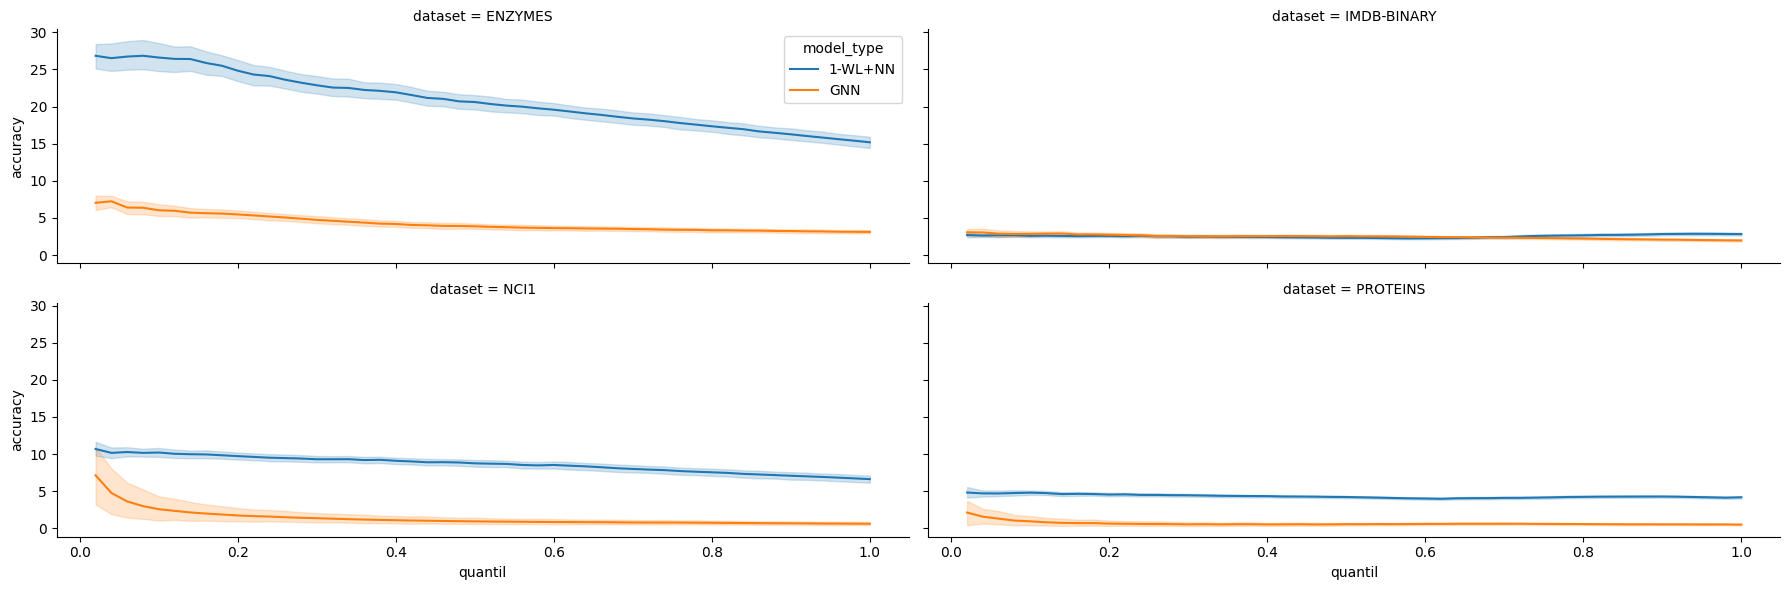

In [8]:
df_abs_diff = df_diff[df_diff['acc_type'] == 'abs_diff']
g = sns.FacetGrid(df_abs_diff, col="dataset", hue="model_type", col_wrap=2, margin_titles=True, aspect=3, legend_out=False)
g.map(sns.lineplot, "quantil", "accuracy")
g.add_legend()

Text(0.5, 1.0, 'Train accuracy - Test accuracy')

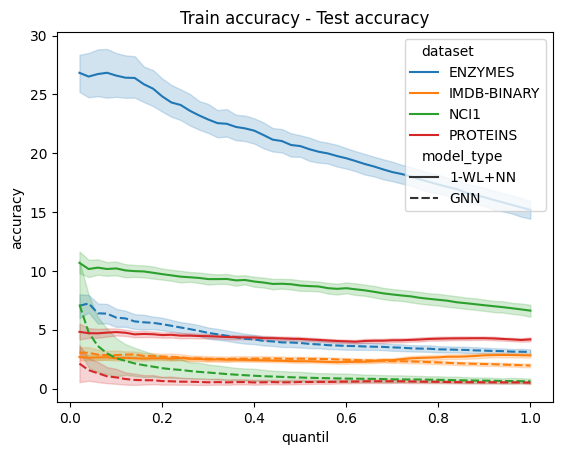

In [9]:
sns.lineplot(data=df_abs_diff, x="quantil", y="accuracy", hue='dataset', style='model_type', err_style='band').set_title("Train accuracy - Test accuracy")

Text(0.5, 1.0, 'Difference accross Model types:\n1-WL+NN - GNN')

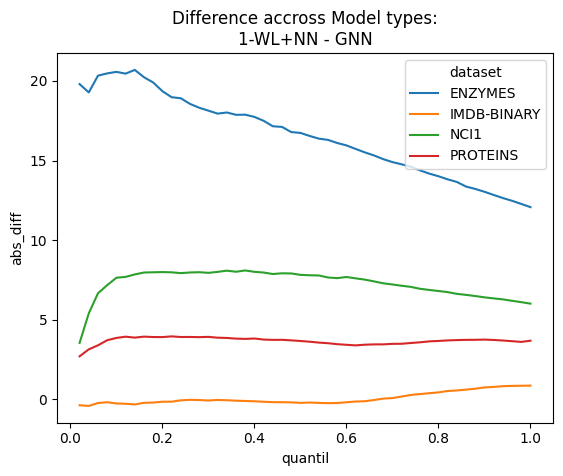

In [10]:
data = []
for (grouped_col, grouped_df) in df_abs_diff.groupby(['dataset', 'quantil']):
    mean_wlnn_diff = grouped_df[grouped_df['model_type'] == '1-WL+NN']['accuracy'].mean()
    mean_gnn_diff = grouped_df[grouped_df['model_type'] == 'GNN']['accuracy'].mean()

    data.append({'dataset' : grouped_col[0], 'quantil' : grouped_col[1], 'abs_diff' : mean_wlnn_diff - mean_gnn_diff})

df_diff_mean = pd.DataFrame(data)
sns.lineplot(data=df_diff_mean, x="quantil", y="abs_diff", hue='dataset').set_title("Difference accross Model types:\n1-WL+NN - GNN")

In [11]:
def calc_svm_boundary_contour(data, x_1, x_2, y, kernel='rbf', gamma='scale', C=1.0, n_points=100):
    """
    Calculate the decision boundary contour of a trained SVM classifier.

    Args:
        X: Numpy array of shape (n_samples, 2) containing the samples.
        Y: Numpy array of shape (n_samples,) containing the labels.
        clf: Trained SVM classifier.
        n_points: Number of points to use for the contour.

    Returns:
        Tuple (xx, yy, Z) where xx and yy are numpy arrays of shape (n_points, n_points) containing the x and y
        coordinates of the contour points and Z is a numpy array of shape (n_points, n_points) containing the
        corresponding decision values.
    """
    X = np.column_stack([data[x_1].to_numpy(), data[x_2].to_numpy()])
    Y = data[y].to_numpy()

    clf = SVC(kernel=kernel, gamma=gamma, C=C)
    clf.fit(X, Y)
    score = clf.score(X, Y)

    # Create a grid of points
    x0_min, x0_max = X[:, 0].min() + 0.1*X[:, 0].mean(), X[:, 0].max() + 0.1*X[:, 0].mean()
    x1_min, x1_max = X[:, 1].min() + 0.1*X[:, 1].mean(), X[:, 1].max() + 0.1*X[:, 1].mean()
    h_x0 = (x0_max - x0_min) / n_points
    h_x1 = (x1_max - x1_min) / n_points
    xx, yy = np.meshgrid(np.arange(x0_min, x0_max, h_x0), np.arange(x1_min, x1_max, h_x1))

    # Calculate the decision values for the grid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    dataframe = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel(), Z.ravel()], columns=["x", "y", "class"])
    dataframe['class'] = dataframe['class'].astype(int)
    return dataframe, score

In [12]:
def get_table(run_id, table_name):
    artifact = api.artifact(f'eric-bill/BachelorThesisExperiments/run-{run_id}-{table_name}:v0', type='run_table')
    artifact_dir = artifact.download()
    
    path = f'{artifact_dir}/{table_name}.table.json'
    with open(path) as file:
        json_dict = json.load(file)
        
    return pd.DataFrame(json_dict["data"], columns=json_dict["columns"])

aggregate_runs = runs_df[runs_df['Tags'] == 'aggregate_analysis']

df_agg = pd.DataFrame()
df_knn = pd.DataFrame()
for index, row in aggregate_runs.iterrows():

    # PCA and TSNE in same table
    for tabel_type in ['tsne', 'pca']:
        df_table = get_table(row['run_id'], tabel_type)
        df_table['dataset'] = row['dataset']
        df_table['model_type'] = row['model_type']
        df_table['table_type'] = tabel_type

        df_agg = pd.concat([df_agg, df_table], ignore_index=True)
    
    # KNN in seperate table
    df_knn_table = get_table(row['run_id'], 'knn')
    df_knn_table['dataset'] = row['dataset']
    df_knn_table['model_type'] = row['model_type']
    df_knn = pd.concat([df_knn, df_knn_table], ignore_index=True)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


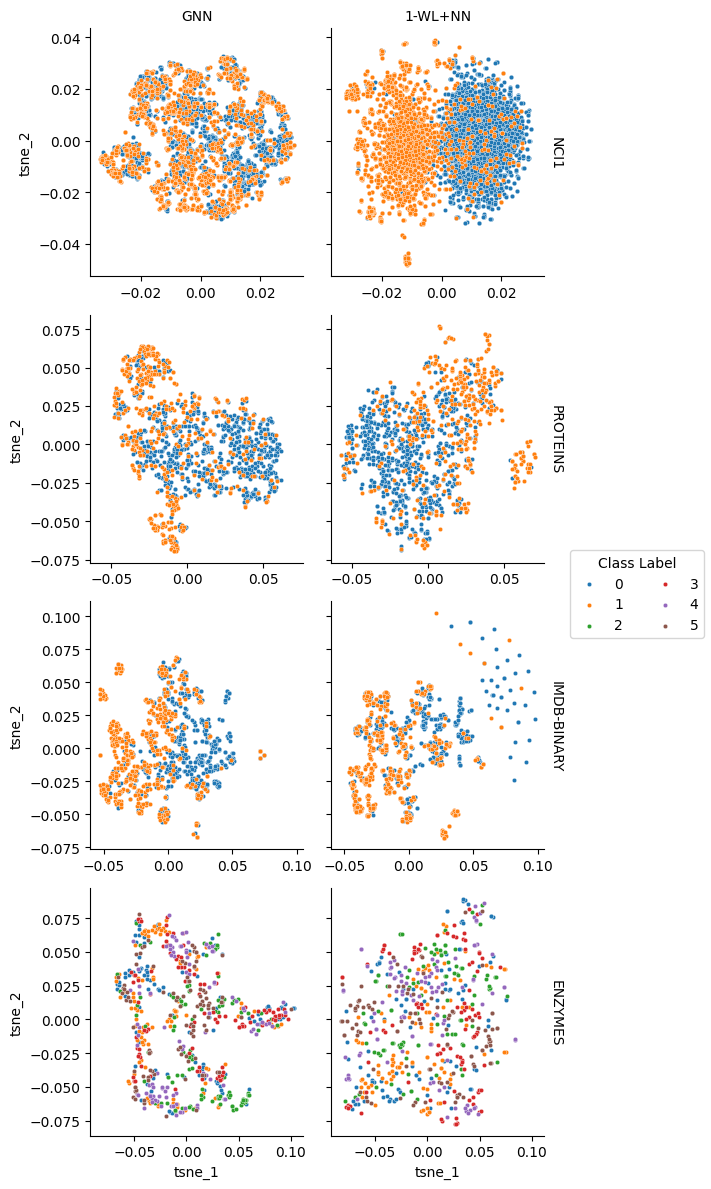

In [13]:
method = 'tsne'

g = sns.FacetGrid(df_agg[df_agg['table_type'] == method], col='model_type', row='dataset', margin_titles=True, sharex='row', sharey='row', hue='class')
g.map_dataframe(sns.scatterplot, x='x', y='y', s=10)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{method}_1', f'{method}_2')

In [14]:
# Process Data for SVM Analysis
df_svm = df_agg.copy()
df_svm['scatter'] = 1

score_dict = {}
for (g_col, g_df) in df_svm.groupby(['dataset', 'model_type', 'table_type']):
    data, score = calc_svm_boundary_contour(g_df, x_1='x', x_2='y', y='class', n_points=100)
    data['dataset'] = g_col[0]
    data['model_type'] = g_col[1]
    data['table_type'] = g_col[2]
    data['scatter'] = 0
    df_svm = pd.concat([df_svm, data], ignore_index=True)

    x_corr = g_df['x'].mean() + (g_df['x'].max() - g_df['x'].min()) * 0.10
    y_corr = g_df['y'].max() + (g_df['y'].max() - g_df['y'].min()) * 0.10
    score_dict[g_col] = (x_corr, y_corr, score)

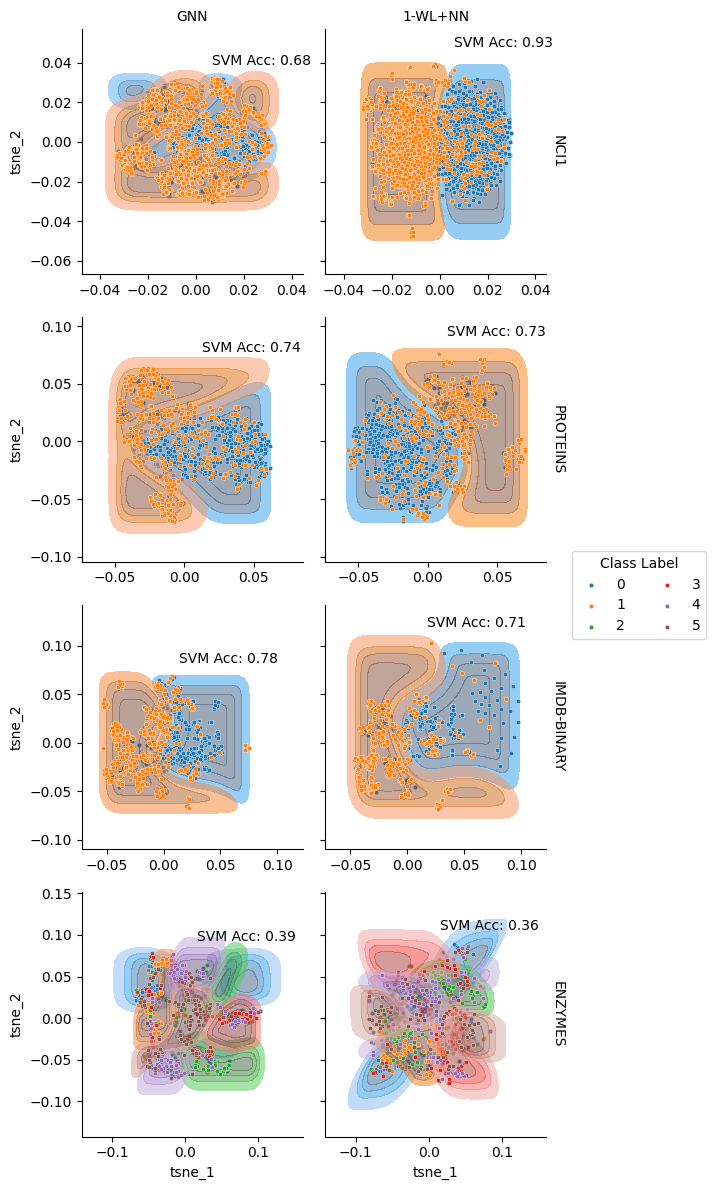

In [15]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

METHOD = 'tsne'

g = sns.FacetGrid(df_svm[df_svm['table_type'] == METHOD], col='model_type', row='dataset', hue='class', margin_titles=True, sharex='row', sharey='row')
g.map_dataframe(custom_plotter, x='x', y='y')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{METHOD}_1', f'{METHOD}_2')

for row in range(g.axes.shape[0]):
    for col in range(g.axes.shape[1]):
        x, y, score = score_dict[(g.row_names[row], g.col_names[col], METHOD)]
        g.axes[row, col].text(x, y, f"SVM Acc: {round(score, 2)}")

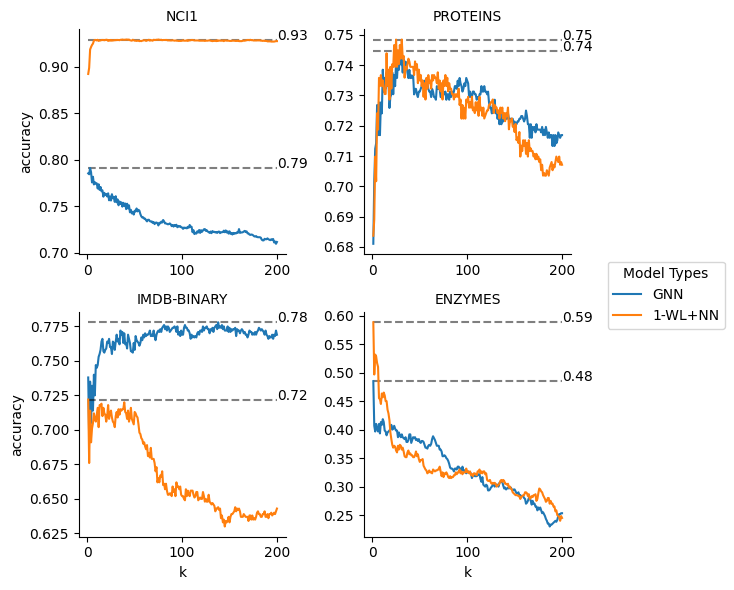

In [16]:
def plot_knn(data, x, y, **kwargs):
    y_max = data[y].max()
    data_max = pd.DataFrame({'max': [y_max] * len(data), x: data[x]})
    
    sns.lineplot(data_max, x=x, y='max', color='black', alpha=0.5, linestyle='--')
    line = sns.lineplot(data=data, x=x, y=y, **kwargs)

    line.axes.text(data[x].max(), y_max, f"{round(y_max, 2)}")

g = sns.FacetGrid(df_knn, hue='model_type', col='dataset', col_wrap=2, margin_titles=True, sharex=False, sharey=False, legend_out=True)
g.map_dataframe(plot_knn, x='k', y='accuracy', legend='full')
g.add_legend(frameon=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(g, "center right", bbox_to_anchor=(1.05, 0.5), title='Model Types')

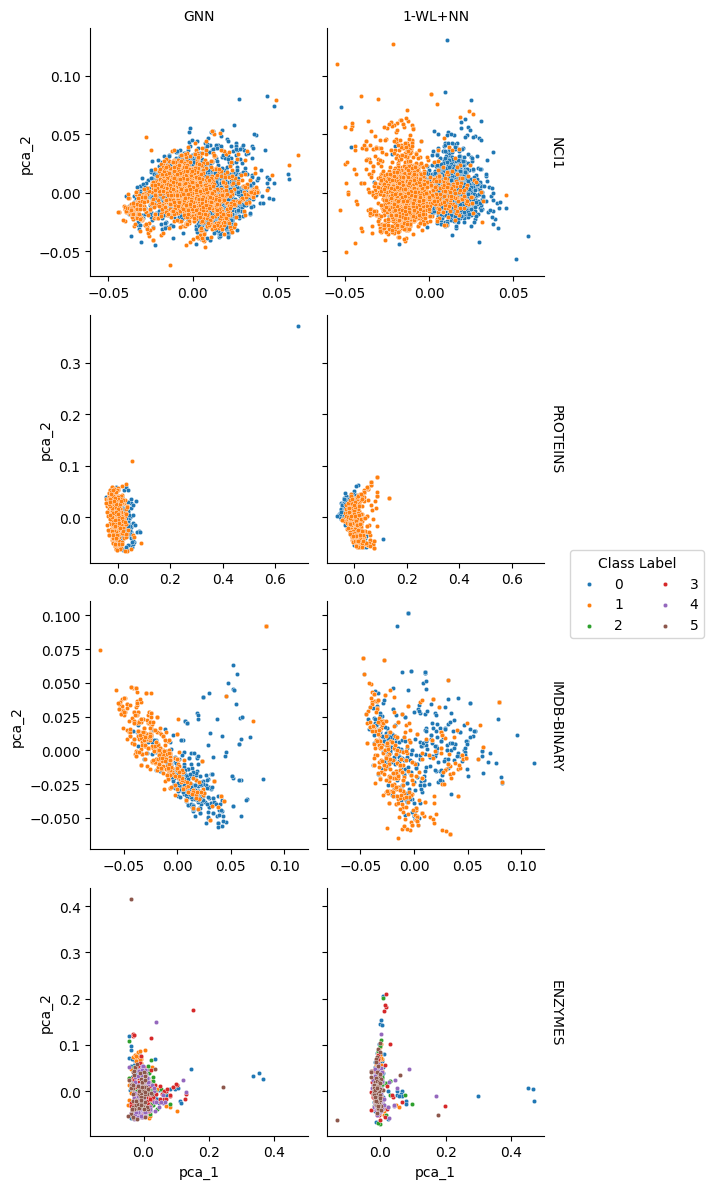

In [17]:
method = 'pca'

g = sns.FacetGrid(df_agg[df_agg['table_type'] == method], col='model_type', row='dataset', margin_titles=True, sharex='row', sharey='row', hue='class')
g.map_dataframe(sns.scatterplot, x='x', y='y', s=10)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{method}_1', f'{method}_2')

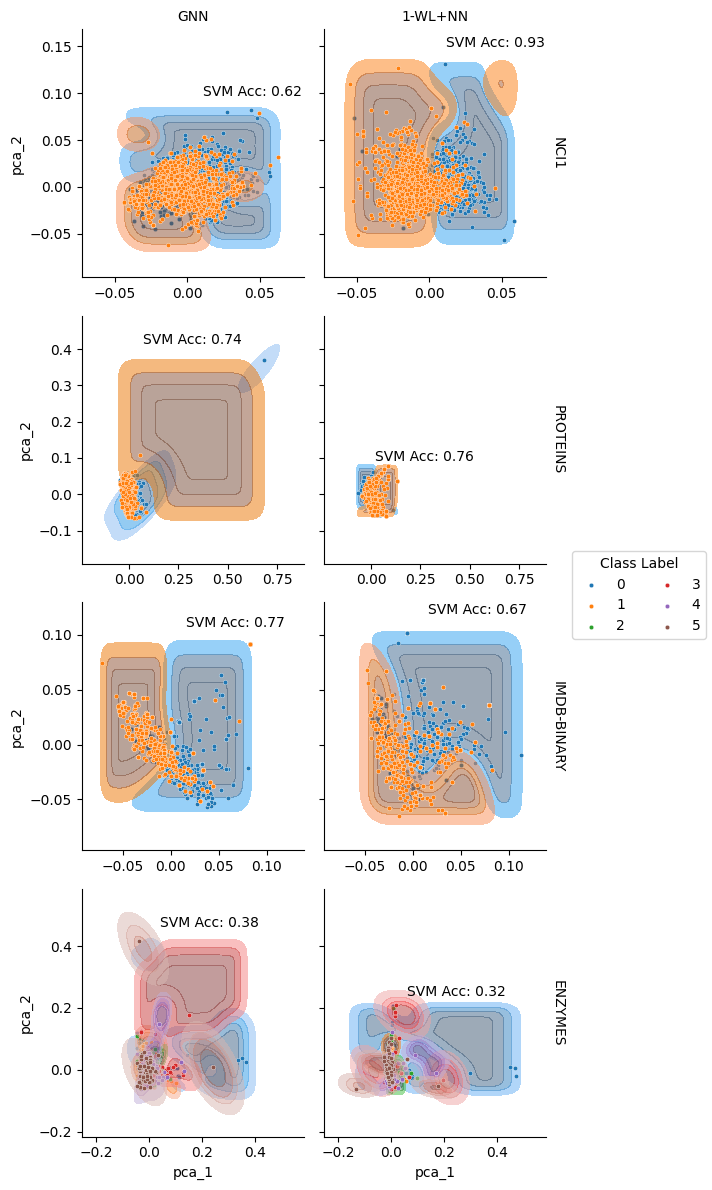

In [18]:
def custom_plotter(data, x, y, **kwargs):
    sns.kdeplot(data=data[data['scatter'] == 0], x=x, y=y, levels=5, alpha=0.5, fill=True, thresh=0.1, **kwargs)
    sns.scatterplot(data=data[data['scatter'] == 1], x=x, y=y, s=10, **kwargs)

METHOD = 'pca'

g = sns.FacetGrid(df_svm[df_svm['table_type'] == METHOD], col='model_type', row='dataset', hue='class', margin_titles=True, sharex='row', sharey='row')
g.map_dataframe(custom_plotter, x='x', y='y')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title='Class Label', frameon=True, ncol=2)
g.set_axis_labels(f'{METHOD}_1', f'{METHOD}_2')

for row in range(g.axes.shape[0]):
    for col in range(g.axes.shape[1]):
        x, y, score = score_dict[(g.row_names[row], g.col_names[col], METHOD)]
        g.axes[row, col].text(x, y, f"SVM Acc: {round(score, 2)}")

In [19]:
df_scores = []
for (key, val) in score_dict.items():
    df_scores.append({'dataset': key[0], 'model_type': key[1], 'table_type': key[2], 'score': val[2]})

df_scores = pd.DataFrame(df_scores)
df_scores.pivot_table(index=['dataset', 'table_type'], columns='model_type', values='score').round(2)

model_type              1-WL+NN   GNN
dataset     table_type               
ENZYMES     pca            0.32  0.38
            tsne           0.36  0.39
IMDB-BINARY pca            0.67  0.77
            tsne           0.71  0.78
NCI1        pca            0.93  0.62
            tsne           0.93  0.68
PROTEINS    pca            0.76  0.74
            tsne           0.73  0.74